<a href="https://colab.research.google.com/github/Mehdi007bond/Predictive_maintenance_Project/blob/main/Predictive_maintenance_Project_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# I started by generating the dataset so i can work


In [22]:
import pandas as pd
import numpy as np
import datetime

# --- 1. Configuration Générale ---
N_LINES = 4  # Nombre de lignes de production à simuler
DAYS_PER_MACHINE = 60
SAMPLES_PER_HOUR = 4
N_SAMPLES_PER_DAY = 24 * SAMPLES_PER_HOUR
TOTAL_SAMPLES_PER_MACHINE = DAYS_PER_MACHINE * N_SAMPLES_PER_DAY

# --- Paramètres de simulation (MIS À JOUR) ---
# Notre "état de panne" (cible=1) commence 58h avant la panne
# pour atteindre notre objectif de 4.02%
FAILURE_STATE_HOURS = 58
FAILURE_STATE_SAMPLES = FAILURE_STATE_HOURS * SAMPLES_PER_HOUR

# --- 2. Profils des Machines ---
def get_machine_parameters(machine_type):
    """Définit les profils de capteurs et de défaillance pour chaque type de machine."""

    if machine_type == 'Fraiseuse':
        return {
            'BASE_TEMP': 45.0, 'TEMP_NOISE': 2.0, 'TEMP_DEGRADE_RATE': 0.1,
            'BASE_VIB': 1.2, 'VIB_NOISE': 0.3, 'VIB_DEGRADE_RATE': 0.1,
            'BASE_CUR': 10.0, 'CUR_NOISE': 0.5, 'CUR_DEGRADE_RATE': 0.08,
            'BASE_TORQUE': 80.0, 'TORQUE_NOISE': 3.0, 'TORQUE_DEGRADE_RATE': 0.15
        }
    elif machine_type == 'Convoyeur':
        return {
            'BASE_TEMP': 30.0, 'TEMP_NOISE': 1.0, 'TEMP_DEGRADE_RATE': 0.05,
            'BASE_VIB': 0.4, 'VIB_NOISE': 0.1, 'VIB_DEGRADE_RATE': 0.03,
            'BASE_CUR': 3.0, 'CUR_NOISE': 0.1, 'CUR_DEGRADE_RATE': 0.15,
            'BASE_TORQUE': 20.0, 'TORQUE_NOISE': 1.0, 'TORQUE_DEGRADE_RATE': 0.05
        }
    elif machine_type == 'Machine_de_finition':
        return {
            'BASE_TEMP': 35.0, 'TEMP_NOISE': 0.5, 'TEMP_DEGRADE_RATE': 0.03,
            'BASE_VIB': 0.2, 'VIB_NOISE': 0.05, 'VIB_DEGRADE_RATE': 0.08,
            'BASE_CUR': 2.0, 'CUR_NOISE': 0.1, 'CUR_DEGRADE_RATE': -0.05,
            'BASE_TORQUE': 10.0, 'TORQUE_NOISE': 0.5, 'TORQUE_DEGRADE_RATE': -0.02
        }
    else:
        raise ValueError("Type de machine inconnu")

# --- 3. Fonction de Génération (Simplifiée) ---
def generate_machine_data(machine_id, machine_type, production_line, start_date):

    print(f"Génération des données pour Machine ID: {machine_id} (Type: {machine_type})...")

    params = get_machine_parameters(machine_type)
    total_samples = TOTAL_SAMPLES_PER_MACHINE

    time_offset_seconds = np.random.randint(0, 30)
    base_timestamps = [start_date + datetime.timedelta(hours=i/SAMPLES_PER_HOUR) for i in range(total_samples)]
    timestamps = [ts + datetime.timedelta(seconds=time_offset_seconds) for ts in base_timestamps]

    # Initialisation des capteurs
    temp = np.random.normal(loc=params['BASE_TEMP'], scale=params['TEMP_NOISE'], size=total_samples)
    vib = np.random.normal(loc=params['BASE_VIB'], scale=params['VIB_NOISE'], size=total_samples)
    curr = np.random.normal(loc=params['BASE_CUR'], scale=params['CUR_NOISE'], size=total_samples)
    torque = np.random.normal(loc=params['BASE_TORQUE'], scale=params['TORQUE_NOISE'], size=total_samples)

    # Feature "Odomètre": total_working_hours
    total_working_hours = (np.arange(total_samples) / SAMPLES_PER_HOUR).round(2)

    # --- CIBLE ML (Simplifiée) ---
    # 0 = 'Healthy', 1 = 'Failing'
    failure = np.zeros(total_samples, dtype=int)

    # Définir le point de panne exact
    failure_sample = total_samples - np.random.randint(N_SAMPLES_PER_DAY * 3, N_SAMPLES_PER_DAY * 15)

    # L'état de panne commence 58h avant
    failing_state_start_sample = failure_sample - FAILURE_STATE_SAMPLES

    # Mettre la cible à 1 pendant l'état de panne
    failure[failing_state_start_sample:failure_sample] = 1

    # Appliquer la dégradation des capteurs PENDANT l'état de panne
    for i in range(failing_state_start_sample, failure_sample):
        progress = (i - failing_state_start_sample) / (failure_sample - failing_state_start_sample)
        temp[i] += params['TEMP_DEGRADE_RATE'] * progress * 20
        vib[i] += params['VIB_DEGRADE_RATE'] * progress * 15
        curr[i] += params['CUR_DEGRADE_RATE'] * progress * 10
        torque[i] += params['TORQUE_DEGRADE_RATE'] * progress * 10

    # --- Assemblage du DataFrame (Simplifié) ---
    df = pd.DataFrame({
        'timestamp': timestamps,
        'production_line': production_line,
        'machine_id': machine_id,
        'machine_type': machine_type,
        'temperature': temp.round(2),
        'vibration': vib.round(4),
        'current': curr.round(3),
        'torque': torque.round(2),
        'total_working_hours': total_working_hours,
        'failure': failure                  # NOTRE CIBLE ML (0 ou 1)
    })

    return df

# --- 4. Boucle Principale de Génération ---
print("Démarrage de la génération du dataset (Cible = failure)...")
all_data_frames = []
start_date = datetime.datetime(2024, 1, 1)
machine_id_counter = 1
machine_types = ['Fraiseuse', 'Convoyeur', 'Machine_de_finition']

for i in range(N_LINES):
    line_name = f"Line_{i+1}"
    print(f"\n--- Génération des données pour {line_name} ---")
    for machine_type in machine_types:
        machine_df = generate_machine_data(
            machine_id=machine_id_counter,
            machine_type=machine_type,
            production_line=line_name,
            start_date=start_date
        )
        all_data_frames.append(machine_df)
        machine_id_counter += 1

# --- 5. Finalisation : Mélange et Sauvegarde ---
print("\nFinalisation du dataset...")
full_dataset = pd.concat(all_data_frames)

print("Tri du dataset par timestamp pour simuler la collecte 'temps réel'...")
full_dataset.sort_values(by='timestamp', inplace=True)
full_dataset.reset_index(drop=True, inplace=True)

print("\nDataset de CLASSIFICATION (4%) généré et mélangé !")
print(f"Nombre total d'échantillons: {len(full_dataset)}")

# Sauvegarde
output_filename = "production_line_STATE_BASED_4_PERCENT_data.csv"
full_dataset.to_csv(output_filename, index=False)
print(f"Dataset sauvegardé sous '{output_filename}'")

# Affichage d'un échantillon
print("\n--- Aperçu du Dataset ---")
print(full_dataset.head(10))

print("\n--- Distribution de la Cible (failure) ---")
print(full_dataset['failure'].value_counts())
target_rate = full_dataset['failure'].mean() * 100
print(f"Pourcentage de 'failure' (1): {target_rate:.2f}%")

Démarrage de la génération du dataset (Cible = failure)...

--- Génération des données pour Line_1 ---
Génération des données pour Machine ID: 1 (Type: Fraiseuse)...
Génération des données pour Machine ID: 2 (Type: Convoyeur)...
Génération des données pour Machine ID: 3 (Type: Machine_de_finition)...

--- Génération des données pour Line_2 ---
Génération des données pour Machine ID: 4 (Type: Fraiseuse)...
Génération des données pour Machine ID: 5 (Type: Convoyeur)...
Génération des données pour Machine ID: 6 (Type: Machine_de_finition)...

--- Génération des données pour Line_3 ---
Génération des données pour Machine ID: 7 (Type: Fraiseuse)...
Génération des données pour Machine ID: 8 (Type: Convoyeur)...
Génération des données pour Machine ID: 9 (Type: Machine_de_finition)...

--- Génération des données pour Line_4 ---
Génération des données pour Machine ID: 10 (Type: Fraiseuse)...
Génération des données pour Machine ID: 11 (Type: Convoyeur)...
Génération des données pour Machine ID: 

# Starting by exploratory data analysis

In [23]:
df = full_dataset
display(df.head(10))
display(df.shape)
df.isna().sum()
display(df.describe())
#


,timestamp,production_line,machine_id,machine_type,temperature,vibration,current,torque,total_working_hours,failure
0,2024-01-01 00:00:01,Line_2,4,Fraiseuse,44.35,1.6787,9.832,82.61,0.0,0
1,2024-01-01 00:00:07,Line_4,11,Convoyeur,30.36,0.2663,3.040,20.45,0.0,0
2,2024-01-01 00:00:08,Line_4,10,Fraiseuse,45.61,1.8837,9.518,76.28,0.0,0
3,2024-01-01 00:00:08,Line_3,7,Fraiseuse,49.55,1.0763,9.917,81.11,0.0,0
4,2024-01-01 00:00:09,Line_4,12,Machine_de_finition,35.88,0.1627,2.118,9.87,0.0,0
5,2024-01-01 00:00:18,Line_1,2,Convoyeur,30.14,0.1792,2.950,20.37,0.0,0
6,2024-01-01 00:00:18,Line_2,5,Convoyeur,29.60,0.2956,3.166,19.43,0.0,0
7,2024-01-01 00:00:19,Line_2,6,Machine_de_finition,34.36,0.2039,1.989,9.19,0.0,0
8,2024-01-01 00:00:25,Line_3,9,Machine_de_finition,34.21,0.2086,2.014,9.84,0.0,0
9,2024-01-01 00:00:27,Line_3,8,Convoyeur,27.95,0.3622,2.752,20.36,0.0,0


(69120, 10)

,timestamp,machine_id,temperature,vibration,current,torque,total_working_hours,failure
count,69120,69120.000000,69120.00000,69120.000000,69120.000000,69120.000000,69120.000000,69120.000000
mean,2024-01-30 23:52:46.416666624,6.500000,36.69142,0.620802,5.013104,36.673018,719.875000,0.040278
min,2024-01-01 00:00:01,1.000000,26.11000,-0.014000,1.249000,8.010000,0.000000,0.000000
25%,2024-01-15 23:56:23,3.750000,30.71000,0.230400,2.064000,10.330000,359.937500,0.000000
50%,2024-01-30 23:52:45,6.500000,35.00000,0.410800,3.004000,20.000000,719.875000,0.000000
75%,2024-02-14 23:49:07,9.250000,43.68000,1.016425,9.676000,78.000000,1079.812500,0.000000
max,2024-02-29 23:45:29,12.000000,52.68000,3.275400,12.060000,92.560000,1439.750000,1.000000
std,NaN,3.452078,6.38812,0.491567,3.579872,30.979148,415.695195,0.196611


In [24]:
df.info()
df.columns

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 69120 entries, 0 to 69119
Data columns (total 10 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   timestamp            69120 non-null  datetime64[ns]
 1   production_line      69120 non-null  object        
 2   machine_id           69120 non-null  int64         
 3   machine_type         69120 non-null  object        
 4   temperature          69120 non-null  float64       
 5   vibration            69120 non-null  float64       
 6   current              69120 non-null  float64       
 7   torque               69120 non-null  float64       
 8   total_working_hours  69120 non-null  float64       
 9   failure              69120 non-null  int64         
dtypes: datetime64[ns](1), float64(5), int64(2), object(2)
memory usage: 5.3+ MB


Index(['timestamp', 'production_line', 'machine_id', 'machine_type',
       'temperature', 'vibration', 'current', 'torque', 'total_working_hours',
       'failure'],
      dtype='object')

In [25]:
import seaborn as sns
import matplotlib.pyplot as plt

for col in ['failure'] :
  col_counts = df[col].value_counts()
  print(col_counts)



failure
0    66336
1     2784
Name: count, dtype: int64


array([[<Axes: title={'center': 'timestamp'}>,
        <Axes: title={'center': 'machine_id'}>,
        <Axes: title={'center': 'temperature'}>],
       [<Axes: title={'center': 'vibration'}>,
        <Axes: title={'center': 'current'}>,
        <Axes: title={'center': 'torque'}>],
       [<Axes: title={'center': 'total_working_hours'}>,
        <Axes: title={'center': 'failure'}>, <Axes: >]], dtype=object)

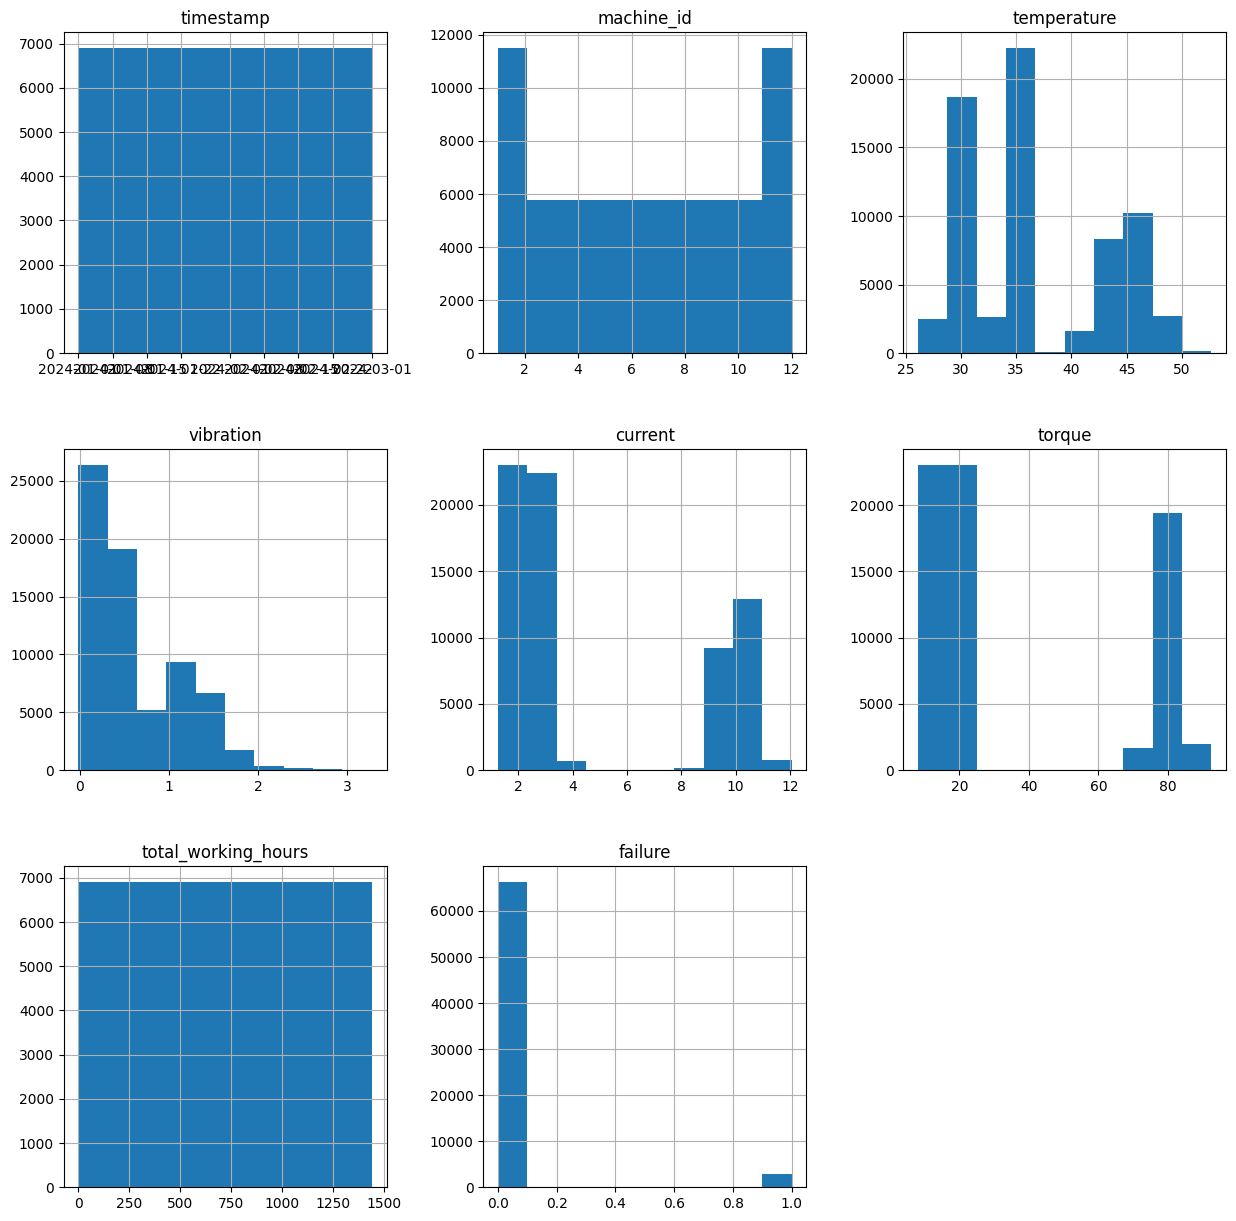

In [26]:
df.hist(figsize=(15,15))

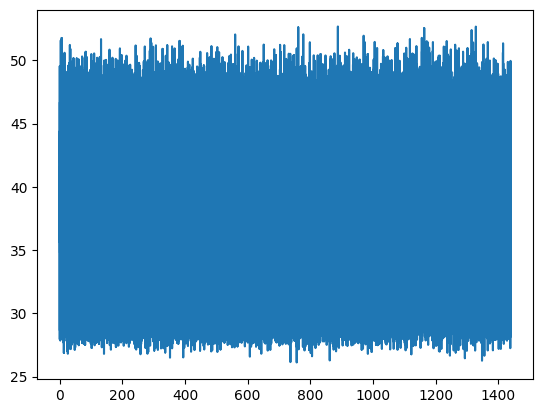

,timestamp,production_line,machine_id,machine_type,temperature,vibration,current,torque,total_working_hours,failure,Failure_Type
11,2024-01-01 00:00:29,Line_1,3,Machine_de_finition,34.81,0.2945,2.058,9.55,0.00,0,No failure
23,2024-01-01 00:15:29,Line_1,3,Machine_de_finition,35.59,0.2047,1.985,10.38,0.25,0,No failure
35,2024-01-01 00:30:29,Line_1,3,Machine_de_finition,35.55,0.2032,1.981,9.13,0.50,0,No failure
47,2024-01-01 00:45:29,Line_1,3,Machine_de_finition,34.78,0.2003,1.886,9.96,0.75,0,No failure
59,2024-01-01 01:00:29,Line_1,3,Machine_de_finition,34.93,0.1473,2.042,11.21,1.00,0,No failure
...,...,...,...,...,...,...,...,...,...,...,...
69071,2024-02-29 22:45:29,Line_1,3,Machine_de_finition,34.41,0.2022,1.809,9.74,1438.75,0,No failure
69083,2024-02-29 23:00:29,Line_1,3,Machine_de_finition,34.18,0.2337,1.998,8.95,1439.00,0,No failure
69095,2024-02-29 23:15:29,Line_1,3,Machine_de_finition,34.91,0.2122,2.030,9.40,1439.25,0,No failure
69107,2024-02-29 23:30:29,Line_1,3,Machine_de_finition,34.37,0.2093,1.981,11.11,1439.50,0,No failure


,timestamp,production_line,machine_id,machine_type,temperature,vibration,current,torque,total_working_hours,failure,Failure_Type
0,2024-01-01 00:00:01,Line_2,4,Fraiseuse,44.35,1.6787,9.832,82.61,0.00,0,No failure
6,2024-01-01 00:00:18,Line_2,5,Convoyeur,29.60,0.2956,3.166,19.43,0.00,0,No failure
7,2024-01-01 00:00:19,Line_2,6,Machine_de_finition,34.36,0.2039,1.989,9.19,0.00,0,No failure
12,2024-01-01 00:15:01,Line_2,4,Fraiseuse,42.91,0.7142,9.525,76.98,0.25,0,No failure
18,2024-01-01 00:15:18,Line_2,5,Convoyeur,27.98,0.5479,2.937,21.04,0.25,0,No failure
...,...,...,...,...,...,...,...,...,...,...,...
69101,2024-02-29 23:30:18,Line_2,5,Convoyeur,29.60,0.3246,3.028,18.41,1439.50,0,No failure
69103,2024-02-29 23:30:19,Line_2,6,Machine_de_finition,34.00,0.1153,2.055,9.65,1439.50,0,No failure
69108,2024-02-29 23:45:01,Line_2,4,Fraiseuse,43.78,0.7359,10.360,78.76,1439.75,0,No failure
69113,2024-02-29 23:45:18,Line_2,5,Convoyeur,29.57,0.4321,3.023,19.91,1439.75,0,No failure


,timestamp,production_line,machine_id,machine_type,temperature,vibration,current,torque,total_working_hours,failure,Failure_Type
3,2024-01-01 00:00:08,Line_3,7,Fraiseuse,49.55,1.0763,9.917,81.11,0.00,0,No failure
8,2024-01-01 00:00:25,Line_3,9,Machine_de_finition,34.21,0.2086,2.014,9.84,0.00,0,No failure
9,2024-01-01 00:00:27,Line_3,8,Convoyeur,27.95,0.3622,2.752,20.36,0.00,0,No failure
15,2024-01-01 00:15:08,Line_3,7,Fraiseuse,43.24,0.9423,9.151,77.44,0.25,0,No failure
20,2024-01-01 00:15:25,Line_3,9,Machine_de_finition,34.60,0.2591,2.082,9.82,0.25,0,No failure
...,...,...,...,...,...,...,...,...,...,...,...
69104,2024-02-29 23:30:25,Line_3,9,Machine_de_finition,34.88,0.1908,2.003,9.76,1439.50,0,No failure
69105,2024-02-29 23:30:27,Line_3,8,Convoyeur,31.73,0.5124,3.077,21.69,1439.50,0,No failure
69110,2024-02-29 23:45:08,Line_3,7,Fraiseuse,47.28,1.3318,9.566,80.56,1439.75,0,No failure
69116,2024-02-29 23:45:25,Line_3,9,Machine_de_finition,35.31,0.2154,2.056,10.71,1439.75,0,No failure


,timestamp,production_line,machine_id,machine_type,temperature,vibration,current,torque,total_working_hours,failure,Failure_Type
1,2024-01-01 00:00:07,Line_4,11,Convoyeur,30.36,0.2663,3.040,20.45,0.00,0,No failure
2,2024-01-01 00:00:08,Line_4,10,Fraiseuse,45.61,1.8837,9.518,76.28,0.00,0,No failure
4,2024-01-01 00:00:09,Line_4,12,Machine_de_finition,35.88,0.1627,2.118,9.87,0.00,0,No failure
13,2024-01-01 00:15:07,Line_4,11,Convoyeur,30.83,0.4647,3.021,17.34,0.25,0,No failure
14,2024-01-01 00:15:08,Line_4,10,Fraiseuse,41.58,1.3329,10.589,83.35,0.25,0,No failure
...,...,...,...,...,...,...,...,...,...,...,...
69098,2024-02-29 23:30:08,Line_4,10,Fraiseuse,45.75,1.2751,10.236,76.38,1439.50,0,No failure
69100,2024-02-29 23:30:09,Line_4,12,Machine_de_finition,34.91,0.1562,2.008,10.17,1439.50,0,No failure
69109,2024-02-29 23:45:07,Line_4,11,Convoyeur,30.47,0.2131,3.042,20.38,1439.75,0,No failure
69111,2024-02-29 23:45:08,Line_4,10,Fraiseuse,45.11,1.7506,9.866,77.19,1439.75,0,No failure


<Figure size 1500x1500 with 0 Axes>

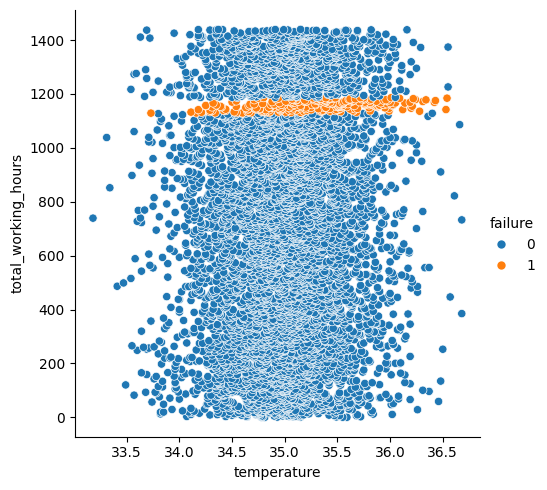

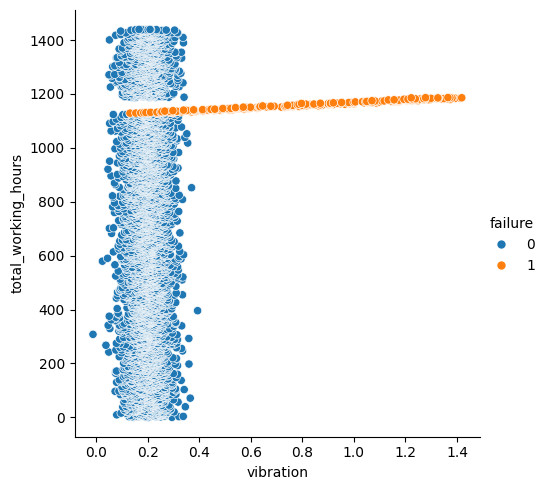

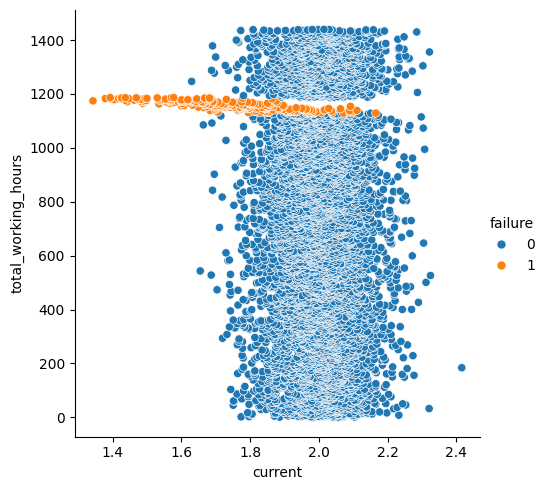

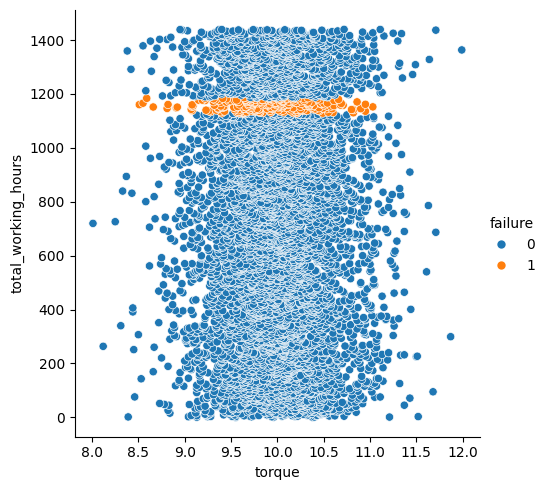

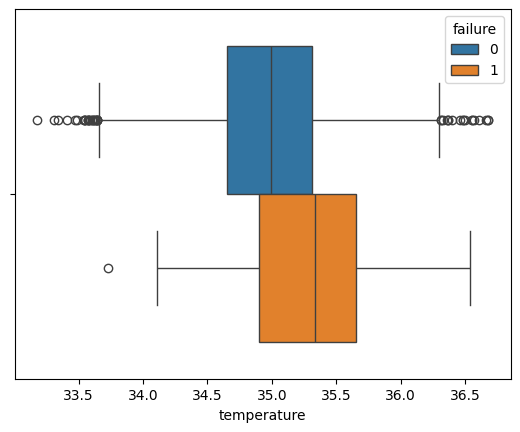

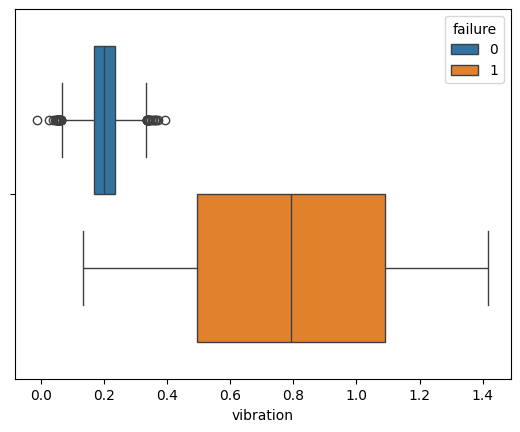

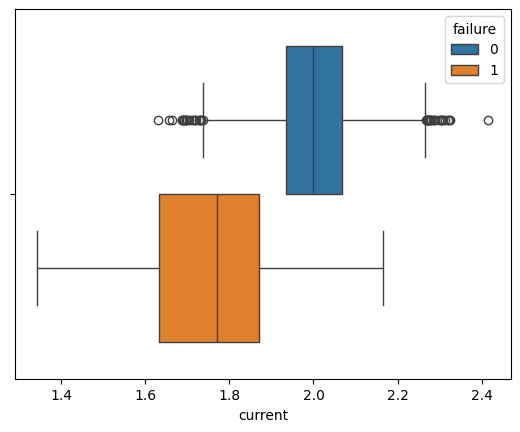

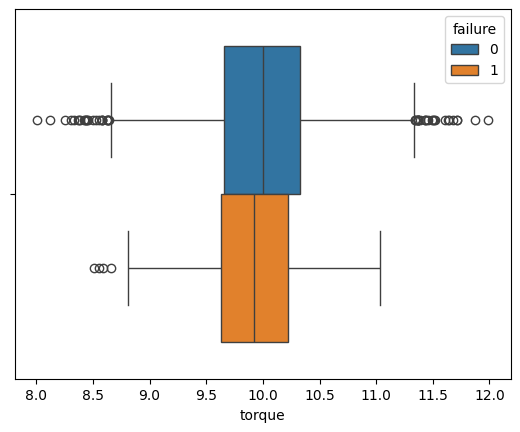

,timestamp,production_line,machine_id,machine_type,temperature,vibration,current,torque,total_working_hours,failure,Failure_Type
11,2024-01-01 00:00:29,Line_1,3,Machine_de_finition,34.81,0.2945,2.058,9.55,0.00,0,No failure
23,2024-01-01 00:15:29,Line_1,3,Machine_de_finition,35.59,0.2047,1.985,10.38,0.25,0,No failure
35,2024-01-01 00:30:29,Line_1,3,Machine_de_finition,35.55,0.2032,1.981,9.13,0.50,0,No failure
47,2024-01-01 00:45:29,Line_1,3,Machine_de_finition,34.78,0.2003,1.886,9.96,0.75,0,No failure
59,2024-01-01 01:00:29,Line_1,3,Machine_de_finition,34.93,0.1473,2.042,11.21,1.00,0,No failure
...,...,...,...,...,...,...,...,...,...,...,...
69071,2024-02-29 22:45:29,Line_1,3,Machine_de_finition,34.41,0.2022,1.809,9.74,1438.75,0,No failure
69083,2024-02-29 23:00:29,Line_1,3,Machine_de_finition,34.18,0.2337,1.998,8.95,1439.00,0,No failure
69095,2024-02-29 23:15:29,Line_1,3,Machine_de_finition,34.91,0.2122,2.030,9.40,1439.25,0,No failure
69107,2024-02-29 23:30:29,Line_1,3,Machine_de_finition,34.37,0.2093,1.981,11.11,1439.50,0,No failure


In [27]:
df.columns
failure_cols = ['temperature', 'vibration', 'current', 'torque']
def classify_failure_type(row):
  for col in failure_cols :
    if row[col] == 1 :
      return col
  return "No failure"

df["Failure_Type"] = df.apply(classify_failure_type, axis=1)


# The following line caused the ValueError and is removed:


plt.plot(df["total_working_hours"], df["temperature"], label="Temperature")
plt.show()

df.tail(100)
df_line2= df[(df['production_line'] == 'Line_2')]
df_line2
df_line1= df[(df['production_line'] == 'Line_1')]
df_line1
df_line3= df[(df['production_line'] == 'Line_3')]
df_line3
df_line4= df[(df['production_line'] == 'Line_4')]
# building a plot where we can see a evolution of each line (1 2 3)
#making a classification of each variable so we ca ddisplay it
df_line1 = df[(df['production_line'] == 'Line_1') & (df['machine_type'] == 'Machine_de_finition')]
criteria=['temperature', 'vibration', 'current', 'torque']


df.head()
display(df_line1 , df_line2 ,df_line3 ,df_line4)
plt.figure(figsize=(15,15))
for i in criteria:
  sns.relplot(x=i ,y='total_working_hours', hue='failure' , data=df_line1)
  plt.show()
for b in criteria:
  sns.boxplot(x=b , hue='failure' , data=df_line1)
  plt.show()
display(df_line1)

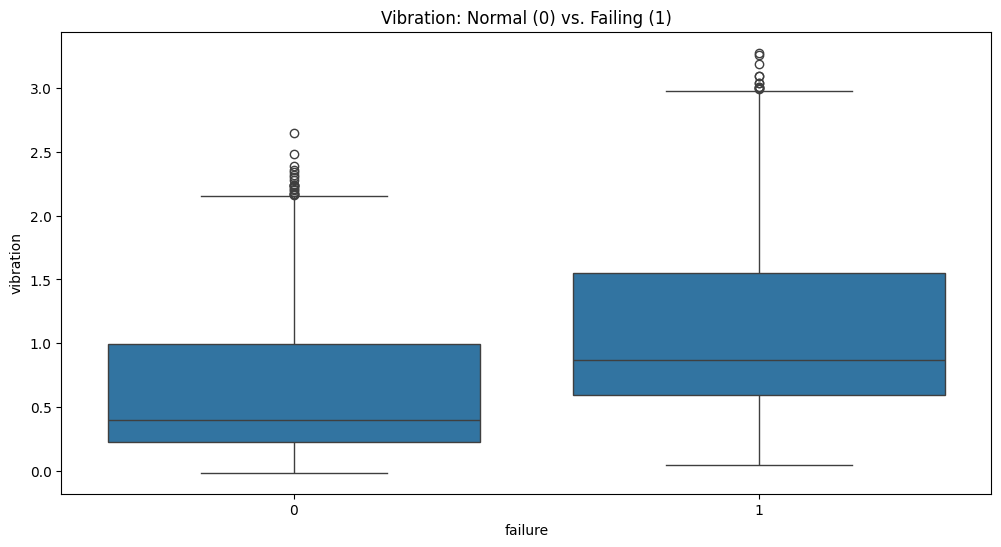

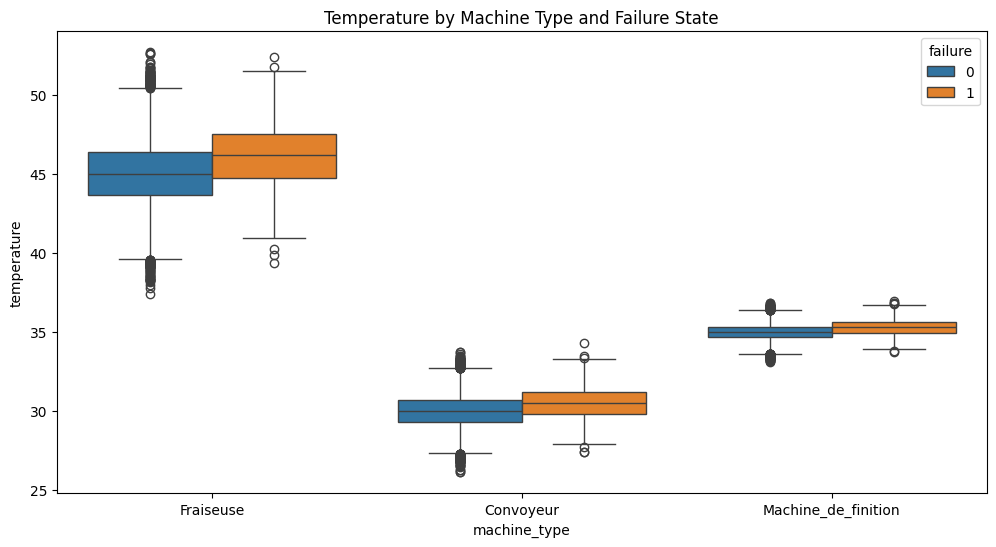

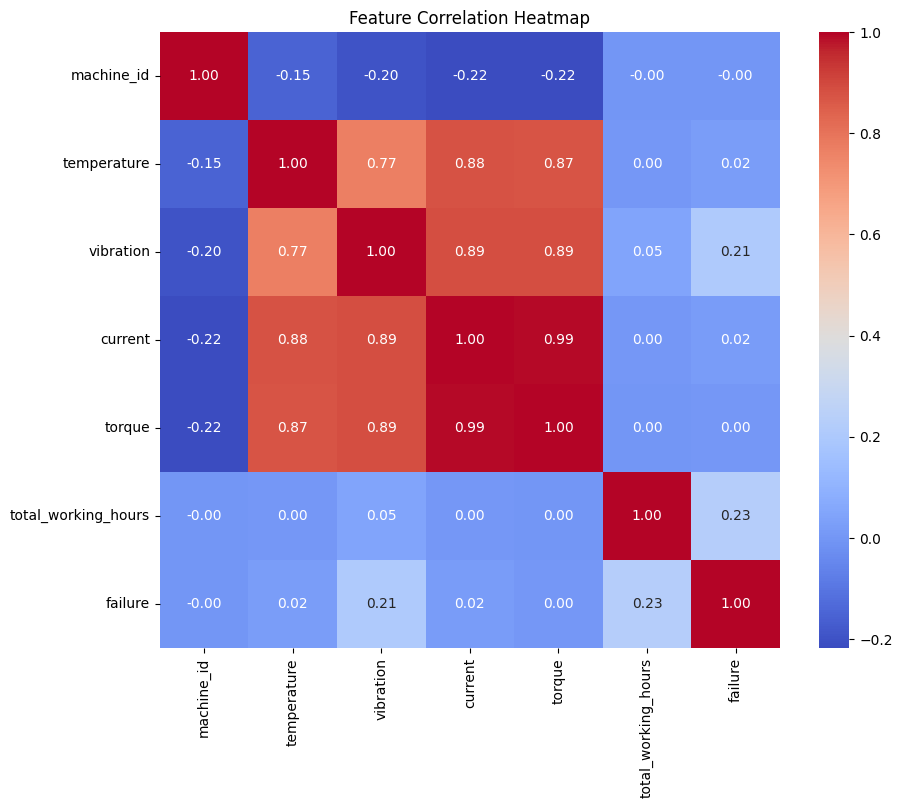

In [28]:
import seaborn as sns
import matplotlib.pyplot as plt

# 1. See the difference between Normal (0) and Failing (1) states

plt.figure(figsize=(12, 6))
sns.boxplot(x='failure', y='vibration', data=df)
plt.title('Vibration: Normal (0) vs. Failing (1)')
plt.show()

# 2. Compare machine types

plt.figure(figsize=(12, 6))
sns.boxplot(x='machine_type', y='temperature', hue='failure', data=df)
plt.title('Temperature by Machine Type and Failure State')
plt.show()

# 3. Check correlations

numeric_cols = df.select_dtypes(include=np.number)
plt.figure(figsize=(10, 8))
sns.heatmap(numeric_cols.corr(), annot=True, fmt='.2f', cmap='coolwarm')
plt.title('Feature Correlation Heatmap')
plt.show()

In [29]:
# Display the correlation between 'current' and 'torque'
print("Correlation between Current and Torque:")
print(numeric_cols.corr().loc['current', 'torque'])

Correlation between Current and Torque:
0.9941542682288251


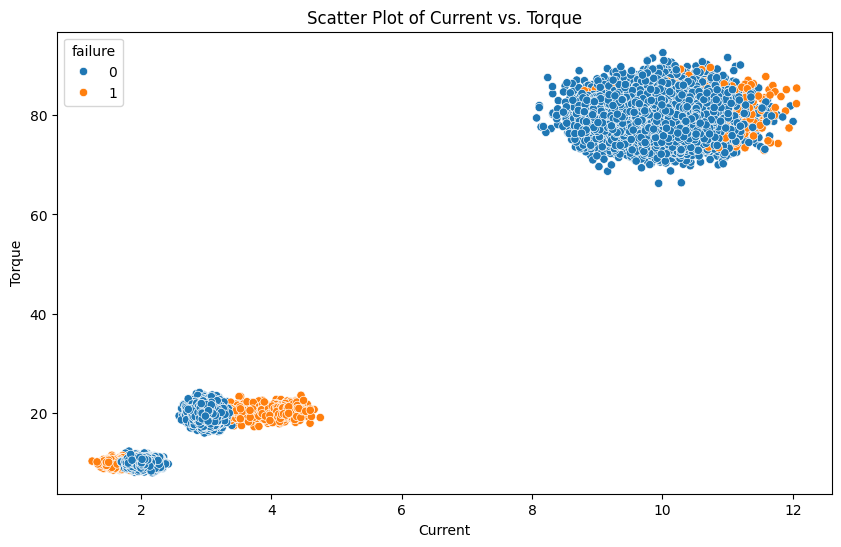

In [30]:

plt.figure(figsize=(10, 6))
sns.scatterplot(x='current', y='torque', hue='failure', data=df)
plt.title('Scatter Plot of Current vs. Torque')
plt.xlabel('Current')
plt.ylabel('Torque')
plt.show()

## After exploring the data and knowing the ones that have the most impact by weight

In [31]:
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# starting building our model

In [32]:
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import classification_report, confusion_matrix
import pandas as pd

# 1. FIRST: Create proper 1-hour ahead labels per machine
print("Creating 1-hour ahead labels per machine...")

# Sort data by machine_id and timestamp to ensure proper time ordering
df_sorted = df.sort_values(['machine_id', 'timestamp']).reset_index(drop=True)

# Create 1-hour ahead failure labels (4 samples = 1 hour based on your data generation)
def create_future_labels(group_df, horizon_samples=4):
    """Create labels for 'failure within next N samples'"""
    group_df = group_df.copy()
    # Check if any failure occurs in the next 'horizon_samples' periods
    group_df['failure_in_1h'] = group_df['failure'].rolling(
        window=horizon_samples, min_periods=1
    ).max().shift(-horizon_samples)
    # Fill NaN values at the end with 0 (no future data available)
    group_df['failure_in_1h'] = group_df['failure_in_1h'].fillna(0).astype(int)
    return group_df

# Apply to each machine separately to avoid cross-machine contamination
df_with_labels = []
for machine_id in df_sorted['machine_id'].unique():
    machine_data = df_sorted[df_sorted['machine_id'] == machine_id].copy()
    machine_labeled = create_future_labels(machine_data, horizon_samples=4)  # 4 samples = 1 hour
    df_with_labels.append(machine_labeled)

df_labeled = pd.concat(df_with_labels, ignore_index=True)
print(f"Added failure_in_1h column. Distribution: {df_labeled['failure_in_1h'].value_counts().to_dict()}")

# 2. Prepare sequences per machine (avoid data leakage between machines)
features = ['temperature', 'vibration', 'current', 'torque', 'total_working_hours']
sequence_length = 24  # 6 hours of history (4 samples per hour * 6 = 24)

def create_sequences(group_df, seq_len, feature_cols):
    """Create sequences from a single machine's data"""
    data = group_df[feature_cols].values
    targets = group_df['failure_in_1h'].values
    timestamps = group_df['timestamp'].values
    indices = group_df.index.values

    X, y, ts, idx = [], [], [], []

    for i in range(len(data) - seq_len + 1):
        X.append(data[i:i+seq_len])
        y.append(targets[i+seq_len-1])  # Target at end of sequence
        ts.append(timestamps[i+seq_len-1])  # Timestamp for this prediction
        idx.append(indices[i+seq_len-1])   # Original dataframe index

    return np.array(X), np.array(y), np.array(ts), np.array(idx)

# Create sequences per machine and combine
all_X, all_y, all_timestamps, all_indices = [], [], [], []

for machine_id in df_labeled['machine_id'].unique():
    machine_data = df_labeled[df_labeled['machine_id'] == machine_id]
    if len(machine_data) >= sequence_length:
        X_machine, y_machine, ts_machine, idx_machine = create_sequences(
            machine_data, sequence_length, features
        )
        all_X.append(X_machine)
        all_y.append(y_machine)
        all_timestamps.append(ts_machine)
        all_indices.append(idx_machine)

# Combine all machines
X = np.vstack(all_X)
y = np.concatenate(all_y)
timestamps = np.concatenate(all_timestamps)
indices = np.concatenate(all_indices)

print(f"Created {len(X)} sequences with shape {X.shape}")
print(f"Target distribution: {np.bincount(y)}")

# 3. Scale features (fit scaler on training data only)
# Reshape for scaling: (samples * timesteps, features)
n_samples, n_timesteps, n_features = X.shape
X_reshaped = X.reshape(-1, n_features)

# Split indices first to ensure proper train/test separation
train_indices, test_indices = train_test_split(
    range(len(X)), test_size=0.2, random_state=42, stratify=y
)

# Scale based on training data only
scaler = MinMaxScaler(feature_range=(0, 1))
X_train_reshaped = X_reshaped[np.repeat(train_indices, n_timesteps)]
scaler.fit(X_train_reshaped)

# Scale all data
X_scaled_reshaped = scaler.transform(X_reshaped)
X_scaled = X_scaled_reshaped.reshape(n_samples, n_timesteps, n_features)

# Final train/test split
X_train, X_test = X_scaled[train_indices], X_scaled[test_indices]
y_train, y_test = y[train_indices], y[test_indices]
timestamps_train, timestamps_test = timestamps[train_indices], timestamps[test_indices]
indices_train, indices_test = indices[train_indices], indices[test_indices]

print(f"Training set: {X_train.shape}, positive rate: {y_train.mean():.3f}")
print(f"Test set: {X_test.shape}, positive rate: {y_test.mean():.3f}")

# 4. Build and train LSTM model
model = Sequential([
    LSTM(units=64, activation='tanh', input_shape=(sequence_length, len(features)),
         return_sequences=False),
    Dropout(0.3),
    Dense(units=32, activation='relu'),
    Dropout(0.2),
    Dense(units=1, activation='sigmoid')
])

# Calculate class weights to handle imbalance
from sklearn.utils.class_weight import compute_class_weight
class_weights = compute_class_weight(
    'balanced',
    classes=np.unique(y_train),
    y=y_train
)
class_weight_dict = {i: class_weights[i] for i in range(len(class_weights))}
print(f"Class weights: {class_weight_dict}")

model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy', 'precision', 'recall']
)

print("Training LSTM model...")
history = model.fit(
    X_train, y_train,
    epochs=20,  # Increased for better convergence
    batch_size=64,
    validation_data=(X_test, y_test),
    class_weight=class_weight_dict,
    verbose=1
)

# 5. Evaluate model
print("\n=== Model Evaluation ===")
test_loss, test_accuracy, test_precision, test_recall = model.evaluate(X_test, y_test, verbose=0)
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"Test Precision: {test_precision:.4f}")
print(f"Test Recall: {test_recall:.4f}")

# 6. Make predictions on ALL sequences (both train and test)
print("\n=== Making Predictions ===")
y_pred_proba = model.predict(X_scaled, verbose=0).flatten()
y_pred_binary = (y_pred_proba >= 0.5).astype(int)

# 7. CREATE THE PREDICTED COLUMN - Map predictions back to original dataframe
print("Adding predicted columns to dataframe...")

# Initialize prediction columns
df_labeled['predicted_failure_1h_prob'] = np.nan
df_labeled['predicted_failure_1h'] = 0

# Map predictions back using stored indices
for i, orig_idx in enumerate(indices):
    df_labeled.loc[orig_idx, 'predicted_failure_1h_prob'] = y_pred_proba[i]
    df_labeled.loc[orig_idx, 'predicted_failure_1h'] = y_pred_binary[i]

# Fill remaining NaN values with 0 (sequences that couldn't be formed)
df_labeled['predicted_failure_1h_prob'] = df_labeled['predicted_failure_1h_prob'].fillna(0)

print(f"\nPrediction column added!")
print(f"Predicted positive rate: {df_labeled['predicted_failure_1h'].mean():.3f}")
print(f"Actual 1h-ahead failure rate: {df_labeled['failure_in_1h'].mean():.3f}")

# 8. Show sample results
print("\n=== Sample Results ===")
sample_data = df_labeled[df_labeled['predicted_failure_1h_prob'] > 0].head(10)
display_cols = ['timestamp', 'machine_id', 'failure', 'failure_in_1h',
                'predicted_failure_1h_prob', 'predicted_failure_1h']
print("Top 10 rows with predictions > 0:")
display(sample_data[display_cols])

# 9. Performance metrics on sequences with predictions
valid_predictions_mask = ~df_labeled['predicted_failure_1h_prob'].isna()
valid_actual = df_labeled[valid_predictions_mask]['failure_in_1h']
valid_predicted = df_labeled[valid_predictions_mask]['predicted_failure_1h']
valid_proba = df_labeled[valid_predictions_mask]['predicted_failure_1h_prob']

print(f"\n=== Classification Report ===")
print(classification_report(valid_actual, valid_predicted))

print(f"\n=== Confusion Matrix ===")
print(confusion_matrix(valid_actual, valid_predicted))

# 10. Show final dataframe with predictions
print(f"\nFinal dataframe shape: {df_labeled.shape}")
print("Columns:", df_labeled.columns.tolist())

# Quick verification - show some high-probability predictions
high_risk = df_labeled[df_labeled['predicted_failure_1h_prob'] > 0.7]
if len(high_risk) > 0:
    print(f"\nFound {len(high_risk)} high-risk predictions (prob > 0.7)")
    display(high_risk[['timestamp', 'machine_id', 'production_line', 'failure_in_1h', 'predicted_failure_1h_prob']].head())
else:
    print("\nNo high-probability failure predictions found")

# Save results
df_labeled.to_csv('production_data_with_predictions.csv', index=False)
print("Results saved to 'production_data_with_predictions.csv'")


Creating 1-hour ahead labels per machine...
Added failure_in_1h column. Distribution: {0: 66300, 1: 2820}
Created 68844 sequences with shape (68844, 24, 5)
Target distribution: [66024  2820]
Training set: (55075, 24, 5), positive rate: 0.041
Test set: (13769, 24, 5), positive rate: 0.041
Class weights: {0: np.float64(0.5213559514568621), 1: np.float64(12.20633865248227)}
Training LSTM model...


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/20
861/861 ━━━━━━━━━━━━━━━━━━━━ 18s 18ms/step - accuracy: 0.6806 - loss: 0.4525 - precision: 0.1046 - recall: 0.8614 - val_accuracy: 0.7018 - val_loss: 0.4288 - val_precision: 0.1190 - val_recall: 0.9805
Epoch 2/20
861/861 ━━━━━━━━━━━━━━━━━━━━ 16s 19ms/step - accuracy: 0.9226 - loss: 0.1924 - precision: 0.3395 - recall: 0.8984 - val_accuracy: 0.8153 - val_loss: 0.2828 - val_precision: 0.1714 - val_recall: 0.9149
Epoch 3/20
861/861 ━━━━━━━━━━━━━━━━━━━━ 16s 19ms/step - accuracy: 0.9230 - loss: 0.1829 - precision: 0.3438 - recall: 0.9107 - val_accuracy: 0.9316 - val_loss: 0.1379 - val_precision: 0.3671 - val_recall: 0.9255
Epoch 4/20
861/861 ━━━━━━━━━━━━━━━━━━━━ 18s 21ms/step - accuracy: 0.9388 - loss: 0.1489 - precision: 0.3956 - recall: 0.9288 - val_accuracy: 0.9747 - val_loss: 0.0930 - val_precision: 0.6311 - val_recall: 0.9220
Epoch 5/20
861/861 ━━━━━━━━━━━━━━━━━━━━ 15s 17ms/step - accuracy: 0.9433 - loss: 0.1390 - precision: 0.4102 - recall: 0.9242 - val_accuracy: 0.9877 - va

,timestamp,machine_id,failure,failure_in_1h,predicted_failure_1h_prob,predicted_failure_1h
23,2024-01-01 05:45:28,1,0,0,1.635253e-09,0
24,2024-01-01 06:00:28,1,0,0,1.065922e-09,0
25,2024-01-01 06:15:28,1,0,0,1.409125e-09,0
26,2024-01-01 06:30:28,1,0,0,2.338888e-09,0
27,2024-01-01 06:45:28,1,0,0,1.296311e-09,0
28,2024-01-01 07:00:28,1,0,0,7.958589e-10,0
29,2024-01-01 07:15:28,1,0,0,6.568394e-10,0
30,2024-01-01 07:30:28,1,0,0,5.736054e-10,0
31,2024-01-01 07:45:28,1,0,0,8.213760e-10,0
32,2024-01-01 08:00:28,1,0,0,1.128502e-09,0



=== Classification Report ===
              precision    recall  f1-score   support

           0       1.00      0.96      0.98     66300
           1       0.49      0.96      0.65      2820

    accuracy                           0.96     69120
   macro avg       0.75      0.96      0.81     69120
weighted avg       0.98      0.96      0.96     69120


=== Confusion Matrix ===
[[63515  2785]
 [  118  2702]]

Final dataframe shape: (69120, 14)
Columns: ['timestamp', 'production_line', 'machine_id', 'machine_type', 'temperature', 'vibration', 'current', 'torque', 'total_working_hours', 'failure', 'Failure_Type', 'failure_in_1h', 'predicted_failure_1h_prob', 'predicted_failure_1h']

Found 3755 high-risk predictions (prob > 0.7)


,timestamp,machine_id,production_line,failure_in_1h,predicted_failure_1h_prob
4093,2024-02-12 15:15:28,1,Line_1,0,0.793383
4094,2024-02-12 15:30:28,1,Line_1,0,0.787877
4095,2024-02-12 15:45:28,1,Line_1,0,0.709325
4187,2024-02-13 14:45:28,1,Line_1,0,0.797251
4188,2024-02-13 15:00:28,1,Line_1,0,0.749237


Results saved to 'production_data_with_predictions.csv'


In [33]:
df_predicted = pd.read_csv('/content/production_data_with_predictions.csv')
df_predicted.head(20)
df_predicted = df_predicted[df_predicted['predicted_failure_1h'] == 1]
df_predicted

,timestamp,production_line,machine_id,machine_type,temperature,vibration,current,torque,total_working_hours,failure,Failure_Type,failure_in_1h,predicted_failure_1h_prob,predicted_failure_1h
4092,2024-02-12 15:00:28,Line_1,1,Fraiseuse,45.88,1.5536,10.232,75.04,1023.00,0,No failure,0,0.608403,1
4093,2024-02-12 15:15:28,Line_1,1,Fraiseuse,44.97,1.6773,10.095,81.48,1023.25,0,No failure,0,0.793383,1
4094,2024-02-12 15:30:28,Line_1,1,Fraiseuse,44.29,1.2112,9.666,75.81,1023.50,0,No failure,0,0.787877,1
4095,2024-02-12 15:45:28,Line_1,1,Fraiseuse,44.21,1.0309,9.949,79.28,1023.75,0,No failure,0,0.709325,1
4096,2024-02-12 16:00:28,Line_1,1,Fraiseuse,48.02,1.0136,9.916,79.61,1024.00,0,No failure,0,0.603055,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
68446,2024-02-22 23:30:09,Line_4,12,Machine_de_finition,34.36,0.1720,2.037,9.68,1271.50,0,No failure,0,0.525695,1
68502,2024-02-23 13:30:09,Line_4,12,Machine_de_finition,35.25,0.2275,2.078,10.61,1285.50,0,No failure,0,0.517645,1
68503,2024-02-23 13:45:09,Line_4,12,Machine_de_finition,35.81,0.2833,2.018,10.13,1285.75,0,No failure,0,0.568130,1
68504,2024-02-23 14:00:09,Line_4,12,Machine_de_finition,35.05,0.2045,1.923,10.19,1286.00,0,No failure,0,0.566837,1
